<a href="https://colab.research.google.com/github/pedrosena138/assin2-bertimbau-benchmark/blob/main/ASSIN2_Portuguese_BERT_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Install dependencies

In [68]:
# Install libs
!pip install datasets transformers evaluate huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Huggingface Login

In [69]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Git config for upload model

In [70]:
# Config git
!apt install git-lfs
!git config --global user.email "pmfsl@cin.ufpe.br"
!git config --global user.name "Pedro Sena"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.


Checking if transformers lib version is gratter then 4.16.0

In [36]:
import transformers

assert transformers.__version__ > '4.16.0'
print(transformers.__version__)

4.26.0


In [37]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)

Num GPUs Available:  1


In [38]:
def check_model(model_name):
    if not model_name:
        raise Exception('Model name not informed')
    if model_name not in MODELS.keys():
        raise Exception("Invalid model name. Please check options in MODELS variable")
    return

In [65]:
import random
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback
from datasets import load_dataset
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, create_optimizer, pipeline
import evaluate

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [71]:
# Plot style
mpl.rcParams['figure.figsize'] = (14, 12)
plt.style.use('seaborn')

BATCH_SIZE = 16
NUM_EPOCHS = 3

#Options: stsb, rte
TASK =  'rte'
MODELS = {
    "b-base": "neuralmind/bert-base-portuguese-cased",
    "b-large": "neuralmind/bert-large-portuguese-cased",
    "multi": "bert-base-multilingual-cased",
    "xr-base": "xlm-roberta-base",
    "xr-large": "xlm-roberta-large"
}

# ASSIN2 Dataset

In [72]:
ASSIN2_TASKS = [
    'rte',
    'stsb'
]

def check_task():
    if not TASK:
        raise Exception('Task not informed')
    if TASK not in ASSIN2_TASKS:
        raise Exception("Invalid task value. Choose 'sts' or 'rte'")
    return

In [73]:
dataset = load_dataset('assin2')

  0%|          | 0/3 [00:00<?, ?it/s]

In [74]:
dataset['train'][0]

{'sentence_pair_id': 1,
 'premise': 'Uma criança risonha está segurando uma pistola de água e sendo espirrada com água',
 'hypothesis': 'Uma criança está segurando uma pistola de água',
 'relatedness_score': 4.5,
 'entailment_judgment': 1}

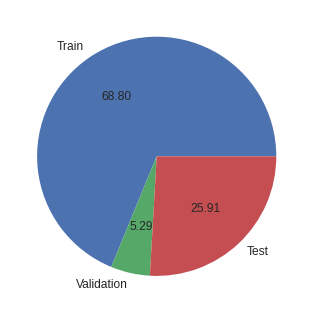

In [75]:
train_size = dataset['train'].num_rows
val_size = dataset['validation'].num_rows
test_size = dataset['test'].num_rows

plt.pie([train_size, val_size, test_size], labels=['Train', 'Validation', 'Test'], autopct='%.2f', textprops={'size': 'large'})
plt.show()

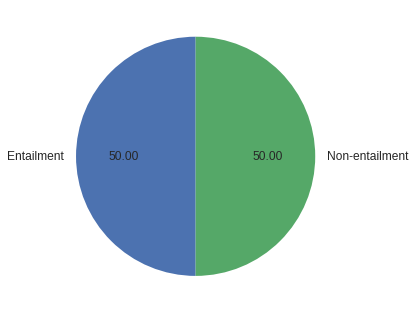

In [76]:
def count_pos_and_neg():
    pos = 0,
    neg = 0
    for key in dataset.keys():
        partial_neg, partial_pos = np.bincount(dataset[key]['entailment_judgment'])
        pos += partial_pos
        neg += int(partial_neg)

    return int(pos), neg

pos, neg = count_pos_and_neg()
plt.pie([pos, neg], labels=['Entailment', 'Non-entailment'], autopct='%.2f', textprops={'size': 'large'}, startangle=90)
plt.show()

# Pre-processamento

In [77]:
def get_relatedness_scores():
    scores = []
    for key in dataset.keys():
        scores.extend(dataset[key]['relatedness_score'])
    return np.array(scores)

def encoder(examples):
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True)
    
def normalize_relatedness_score(examples):
    scores = np.array(examples['relatedness_score'])
    return {'label': scaler.transform(scores.reshape(-1, 1)).reshape(1, -1)[0]}

In [103]:
model_name = 'b-base'
check_model(model_name)

tokenizer = AutoTokenizer.from_pretrained(MODELS[model_name], model_max_length=train_size)

encoded_dataset = dataset.map(encoder, batched=True)

check_task()
if TASK == 'stsb':
    # Normalize relatedness scores
    # scaler = MinMaxScaler()
    # scores = get_related_scores()
    # scaler.fit(scores.reshape(-1, 1))
    # encoded_dataset = encoded_dataset.map(normalize_relatedness_score, batched=True)
    encoded_dataset = encoded_dataset.map(lambda x: {'label': x['entailment_judgment']}, batched=True)
else:
    encoded_dataset = encoded_dataset.map(lambda x: {'label': x['entailment_judgment']}, batched=True)

pre_encoder_columns = set(dataset["train"].features)
encoder_columns = list(set(encoded_dataset["train"].features) - pre_encoder_columns)

print("\nColumns added after preprocessing:", encoder_columns)


Columns added after preprocessing: ['label', 'attention_mask', 'input_ids', 'token_type_ids']


# Fine-tuning

In [83]:
if TASK == 'stsb':
    metric = evaluate.load('pearsonr')
else:
    metric = evaluate.combine(['accuracy', 'f1'])

def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions
    if TASK == "stsb":
        predictions = predictions[:, 0]
    else:
        predictions = np.argmax(predictions, axis=1)

    return metric.compute(predictions=predictions, references=labels)

In [84]:
def load_model(model_name, total_train_steps):
    from_pt = True if model_name == MODELS["b-large"] else False
    optimizer, schedule = create_optimizer(
        init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
    )

    if TASK == 'stsb':
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, from_pt=from_pt)
        model.compile(
            optimizer=optimizer,
            loss='mse'
        )
    elif TASK == 'rte':
        id2label = {0: "None", 1: "Entails"}
        label2id = {"None": 0, "Entails": 1}
        
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name,
                                          num_labels=2,
                                          id2label=id2label, 
                                          label2id=label2id,
                                          from_pt=from_pt)   
        model.compile(
                optimizer=optimizer,
        )
            
    return model

In [104]:
batches_per_epoch = train_size // BATCH_SIZE
total_train_steps = int(batches_per_epoch * NUM_EPOCHS)

model = load_model(MODELS[model_name], total_train_steps)
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Model: "tf_bert_for_sequence_classification_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108923136 
                                                                 
 dropout_265 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,924,674
Trainable params: 108,924,674
Non-trainable params: 0
_________________________________________________________________


In [105]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_set = model.prepare_tf_dataset(
    encoded_dataset["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    encoded_dataset["validation"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [107]:
metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=tf_validation_set
)

model_checkpoint = MODELS[model_name].split("/")[-1]
push_to_hub_model_id = f"{model_checkpoint}-finetuned-{TASK}-assin2"

tensorboard_callback = TensorBoard(log_dir=f"./{push_to_hub_model_id}/logs")

push_to_hub_callback = PushToHubCallback(
    output_dir=f"./{push_to_hub_model_id}",
    tokenizer=tokenizer,
    hub_model_id=push_to_hub_model_id,
)

callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]

print(f'\nTask: {TASK}')
print(f'Model: {push_to_hub_model_id}')
history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=NUM_EPOCHS, callbacks=callbacks)

/content/bert-base-portuguese-cased-finetuned-rte-assin2 is already a clone of https://huggingface.co/pmfsl/bert-base-portuguese-cased-finetuned-rte-assin2. Make sure you pull the latest changes with `repo.git_pull()`.



Task: rte
Model: bert-base-portuguese-cased-finetuned-rte-assin2
Epoch 1/3
  6/406 [..............................] - ETA: 1:05 - loss: 0.7032

406/406 [==============================] - 140s 307ms/step - loss: 0.3735 - val_loss: 0.2300 - accuracy: 0.9274 - f1: 0.9300
Epoch 2/3
406/406 [==============================] - 105s 259ms/step - loss: 0.2044 - val_loss: 0.1596 - accuracy: 0.9496 - f1: 0.9499
Epoch 3/3
406/406 [==============================] - 114s 280ms/step - loss: 0.1201 - val_loss: 0.1637 - accuracy: 0.9476 - f1: 0.9482


In [116]:
def plot_loss(history, label='Loss'):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'], label='Val ' + label)
  
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss', fontsize=16)
  plt.legend()

def plot_metrics(history, metrics):
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend();

def plot_confusion_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

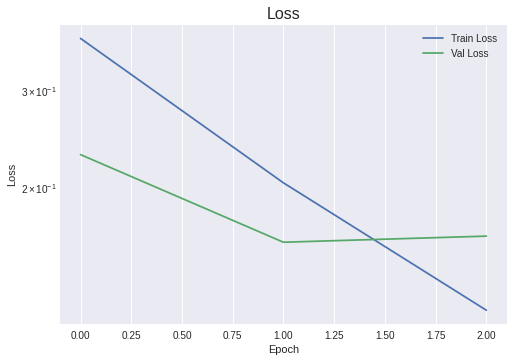

In [111]:
plot_loss(history)

In [113]:
tokenized = tokenizer(dataset['test']['premise'], dataset['test']['hypothesis'], return_tensors="np", padding="longest")
label_col = 'relatedness_score' if TASK == 'stsb' else 'entailment_judgment'
labels = dataset['test'][label_col]

# tokenized
outputs = model(tokenized).logits

classifications = np.argmax(outputs, axis=1)
print(classifications)

ResourceExhaustedError: ignored

KeyError: ignored

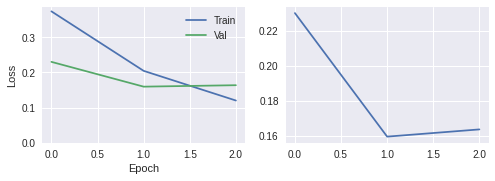

In [118]:
plot_metrics(history, metrics=history.history.keys())

In [ ]:
results = model.evaluate(tf_test_dataset.batch(20), batch_size=2048, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.8500600457191467
accuracy :  0.26618704199790955



Legitimate Transactions Detected (True Negatives):  11
Legitimate Transactions Incorrectly Detected (False Positives):  5
Fraudulent Transactions Missed (False Negatives):  97
Fraudulent Transactions Detected (True Positives):  26
Total Fraudulent Transactions:  123


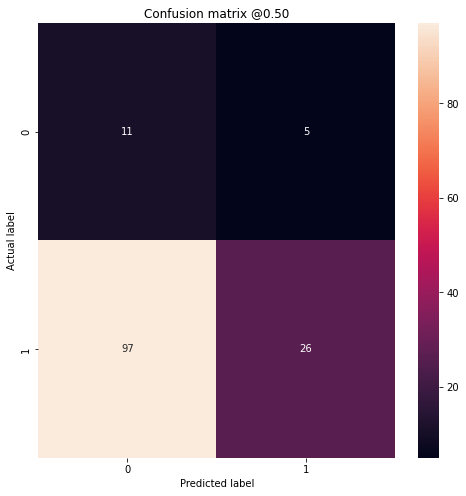

In [ ]:
test_sentences = test_dataset['text'].values.tolist()
encodings = tokenizer(test_sentences, truncation=True, padding='longest', return_tensors="np")
outputs = model(encodings).logits

y = test_dataset['label'].values.tolist()
y_hat = np.argmax(outputs, axis=1)

plot_confusion_matrix(y, y_hat)